In [86]:
import os
os.chdir('../../')

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
pal = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
sns.set_palette(sns.color_palette(pal))

pal = sns.color_palette("tab10", 10)
pal = pal.as_hex()

sns.set_theme()
rc={'font.size': 19, 'axes.labelsize': 20, 'legend.fontsize': 18, 
    'axes.titlesize': 21, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
sns.set(rc=rc)
sns.set_style('white')

import sys
sys.path.append('./')
from GPEC import *
from GPEC.utils import * # utility functions
from Tests.Models import xgb_models

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


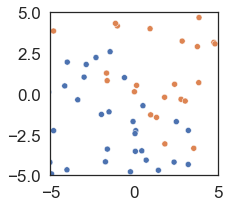

In [87]:
np.random.seed(2)
def f_data(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y + np.random.normal(0, 2.0, size = len(x))
    return (output >= 0)*1.

def f_out(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y
    return output

def f_prob(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y
    output = utils_np.sigmoid(output)
    return np.vstack((1-output, output)).transpose()

def f_prob_singleclass(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y
    output = utils_np.sigmoid(output)
    return output
# def f(data):

#     x = data[:,0]
#     y = data[:,1]

#     output = np.abs(x) + y + np.random.normal(0, 1.0, size = len(x))
#     return (output >= 0)*1.

def db(data):
    x = data[:,0]
    y = data[:,1]

    output = -x
    return output
x_train = np.random.uniform(-10,10, size = (200,2))
x_test = np.random.uniform(-5,5, size = (1000,2))
y_train = f_data(x_train)
y_test = f_data(x_test)

fig, ax = plt.subplots(1,1, figsize = (3,3))
sns.scatterplot(x = x_train[:,0], y = x_train[:,1], hue = f_data(x_train))
plt.ylim((-5,5))
plt.xlim((-5,5))
ax.get_legend().remove()
plt.show()


In [88]:


d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

params = {
    "eta": 1.0,
    # "gamma": 10,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgb.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

pred =(model.predict(d_test) >= 0.5)*1
# see how well we can order people by survival
print(metrics.accuracy_score(y_test, pred))
print(metrics.roc_auc_score(y_test, pred))
print('done!')
'''
model_path = './Files/Models/model_census.json'
model = xgb.Booster()
model.load_model(model_path)
'''

[0]	test-logloss:0.59463
[24]	test-logloss:0.53163
0.813
0.8132259408193018
done!


"\nmodel_path = './Files/Models/model_census.json'\nmodel = xgb.Booster()\nmodel.load_model(model_path)\n"

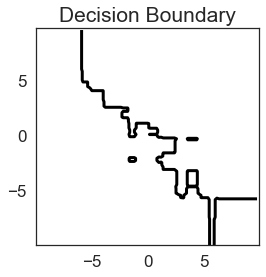

In [89]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(1,  1, figsize=(4, 4), sharey=True, sharex = True)
axes.contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)

# axes[1,0].get_legend().remove()
# axes[1,1].get_legend().remove()


plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()

In [90]:
explainer = 'kernelshap'
if explainer == 'kernelshap':
    gt_model = f_prob_singleclass
    output_shape = 'singleclass'
else:
    gt_model = f_prob
    output_shape = 'multiclass'
f_blackbox = xgb_models.xgboost_wrapper(model = model, output_shape = output_shape)

lam = 5
rho = 0.01
gpec = GPEC.GPEC_Explainer(
    f_blackbox,
    x_train,
    y_train,
    explain_method = explainer,
    use_gpec = False,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 50,
    )


attr_list, var_list, ci_list = gpec.explain(x_test, y_test)
print('DONE')

gpec = GPEC.GPEC_Explainer(
    gt_model,
    x_train,
    y_train,
    explain_method = explainer,
    use_gpec = False,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 50,
    )


attr_list_gt, var_list_gt, ci_list_gt = gpec.explain(x_test, y_test)

done!


100%|██████████| 1000/1000 [00:04<00:00, 212.44it/s]


DONE


100%|██████████| 1000/1000 [00:02<00:00, 350.90it/s]


In [91]:
# spearman rank correlation
#using absolute value
import scipy
tmp = np.abs(attr_list)
order = tmp.argsort(axis = 1)
ranks = order.argsort(axis = 1)+1
a = ranks

tmp = np.abs(attr_list_gt)
order = tmp.argsort(axis = 1)
ranks = order.argsort(axis = 1)+1
b = ranks

corr_list = []
for i in range(a.shape[0]):
    corr_list.append(scipy.stats.spearmanr(a[i,:], b[i,:])[0])
corr_list = np.array(corr_list)
np.tanh(np.arctanh(corr_list).mean())

0.9999999998330656

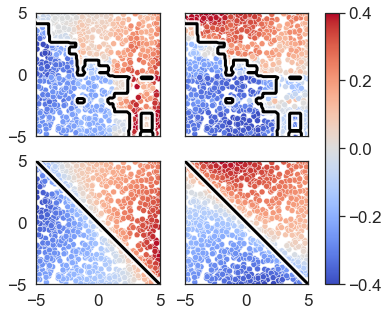

In [92]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(2,  2, figsize=(7, 5), sharey=True, sharex = True)

#~~~~~~~~~~~~~~~~~~~
import matplotlib.colors as mcolors
import matplotlib.cm as cm
# vmin = min(attr_list.min(), attr_list_gt.min())
# vmax = min(attr_list.max(), attr_list_gt.max())
vmin = -0.4
vmax = 0.4
vcenter = 0
cmap = "coolwarm"

normalize = mcolors.TwoSlopeNorm(vmin=vmin, vcenter = vcenter, vmax=vmax)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(attr_list[:,0])
fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(scalarmappaple, ax=axes.ravel().tolist())
cmap_single = mcolors.LinearSegmentedColormap.from_list("", ["Chartreuse", "White"])
#~~~~~~~~~~~~~~~~~~~

axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list[:,0], ax = axes[0,0], palette = "coolwarm", legend = False, norm = normalize)

axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list[:,1], ax = axes[0,1], palette = "coolwarm", legend = False, norm = normalize)
#plt.contourf(xx,yy,probs)

probs = f_prob(data_tmp)[:,1].reshape(xx.shape)
axes[1,0].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[1,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list_gt[:,0], ax = axes[1,0], palette = "coolwarm", legend = False, norm = normalize)

axes[1,1].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[1,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list_gt[:,1], ax = axes[1,1], palette = "coolwarm", legend = False, norm = normalize)



# plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
# plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
# plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.savefig('./Paper/Images/fig_toy_attributions.svg')
plt.show()

## Mean Squared Error (MSE)

In [93]:
from sklearn.metrics import mean_squared_error
# print(mean_squared_error(attr_list_gt[:,0], attr_list[:,0]))
# print(mean_squared_error(attr_list_gt[:,1], attr_list[:,1]))
print(mean_squared_error(attr_list_gt, attr_list))
# np.linalg.norm(attr_list - attr_list_gt)

0.010924126114785482


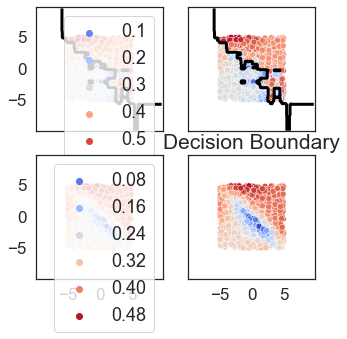

In [96]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(2,  2, figsize=(5, 5), sharey=True, sharex = True)
axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list, axis = 1), ax = axes[0,0], palette = "coolwarm")

axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list, axis = 1), ax = axes[0,1], palette = "coolwarm")
# axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
#plt.contourf(xx,yy,probs)

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list_gt, axis = 1), ax = axes[1,0], palette = "coolwarm")

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list_gt, axis = 1), ax = axes[1,1], palette = "coolwarm")

# axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()


plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()

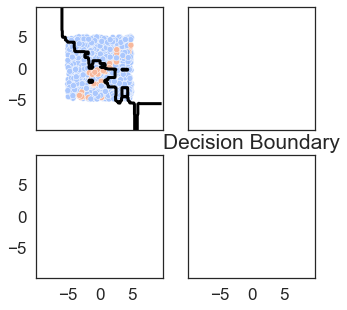

0.118


In [97]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

disagree_list = (attr_list.argmax(axis = 1) != attr_list_gt.argmax(axis = 1))*1

fig, axes = plt.subplots(2,  2, figsize=(5, 5), sharey=True, sharex = True)
axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = disagree_list, ax = axes[0,0], palette = "coolwarm")

axes[0,0].get_legend().remove()
#plt.contourf(xx,yy,probs)


plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()
print(disagree_list.mean())

0.5865198301799537
0.12442245585728978


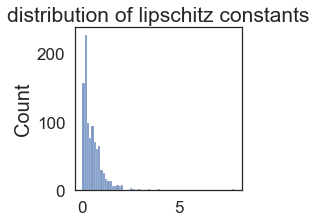

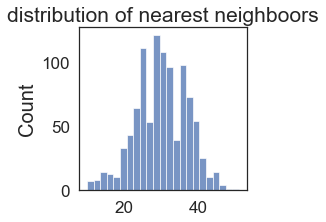

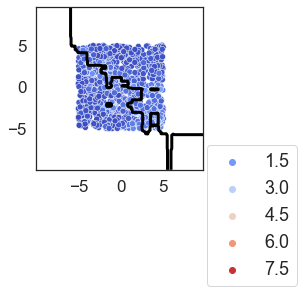

In [98]:
def robustness(x_test, attr_list, eps):
    dist_mat = scipy.spatial.distance_matrix(x_test, x_test)
    attr_mat = scipy.spatial.distance_matrix(attr_list, attr_list)
    lip_mat = np.divide(attr_mat, dist_mat, out=np.zeros_like(attr_mat), where=dist_mat!=0)

    lip_list = []
    nn_list = []
    for i in range(x_test.shape[0]):
        sample = x_test[i,...]
        nn_idx = np.where(dist_mat[i,:] < eps)[0]
        nn_list.append(len(nn_idx))
        l = lip_mat[i,nn_idx].max()
        lip_list.append(l)
    lip_list = np.array(lip_list)
    nn_list = np.array(nn_list)
    return lip_list, nn_list


eps = 1
lip_list, nn_list = robustness(x_test, attr_list, eps)
lip_list_gt, _ = robustness(x_test, attr_list_gt, eps)
print(lip_list.mean())
print(lip_list_gt.mean())


########### plot
fig, axes = plt.subplots(1,  1, figsize=(3, 3), sharey=True, sharex = True)
sns.histplot(lip_list)
plt.title("distribution of lipschitz constants")
plt.show()

fig, axes = plt.subplots(1,  1, figsize=(3, 3), sharey=True, sharex = True)
sns.histplot(nn_list)
plt.title("distribution of nearest neighboors")
plt.show()

fig, axes = plt.subplots(1,  1, figsize=(3, 3), sharey=True, sharex = True)
axes.contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = lip_list, ax = axes, palette = "coolwarm")
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.show()


In [99]:
explainer = 'lime'
if explainer == 'kernelshap':
    gt_model = f_prob_singleclass
    output_shape = 'singleclass'
else:
    gt_model = f_prob
    output_shape = 'multiclass'
f_blackbox = xgb_models.xgboost_wrapper(model = model, output_shape = output_shape)

x_tmp = np.random.uniform(-10,10, size = (40,2))

linspace_list = []
for feat_idx in range(x_train.shape[1]):
    linspace_list.append(np.linspace(-10, 10, 20, dtype = x_train.dtype))

xx_list = np.meshgrid(*linspace_list)
xx_list = [xx.transpose() for xx in xx_list]
ravel_list = [xx.ravel() for xx in xx_list]
x_tmp = np.vstack(ravel_list).transpose()
y_tmp = np.zeros(x_tmp.shape[0])

lam = 1
rho = 0.5
gpec = GPEC.GPEC_Explainer(
    f_blackbox,
    x_tmp,
    y_tmp,
    explain_method = explainer,
    use_gpec = True,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 200,
    # manifold_samples = manifold_samples,
    # geo_matrix = geo_matrix,
    # tr_attributions = tr_attributions,
    calc_attr_during_pred = False,
    )
manifold_samples = gpec.manifold_samples
geo_matrix = gpec.geo_matrix
# tr_attributions = attr_list

_, var_list, ci_list = gpec.explain(x_test, y_test)
print('DONE')

gpec = GPEC.GPEC_Explainer(
    gt_model,
    x_tmp,
    y_tmp,
    explain_method = explainer,
    use_gpec = True,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 200,
    # manifold_samples = manifold_samples_gt,
    # geo_matrix = geo_matrix_gt,
    # tr_attributions = tr_attributions_gt,
    calc_attr_during_pred = False,
    )
manifold_samples_gt = gpec.manifold_samples
geo_matrix_gt = gpec.geo_matrix
# tr_attributions_gt = attr_list_gt


_, var_list_gt, ci_list_gt = gpec.explain(x_test, y_test)

done!
Generating Explanations...


100%|██████████| 400/400 [00:02<00:00, 174.46it/s]


Sampling Boundary...


100%|██████████| 588/588 [00:00<00:00, 6204.69it/s]


# Samples Not Converged: 370
Avg Gap: 0.23342252518679646
Max Gap: 0.41562649607658386
Samples limited to: 200
Building EG Kernel...


define_rTree:   0%|          | 0/200 [00:00<?, ?it/s]divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
di

Training GP...
Number of Batches: 1


Batch Progress: 0it [00:00, ?it/s]

----------------
device: cpu
Optimizer: Adam


100%|██████████| 100/100 [00:03<00:00, 26.31it/s, Loss=33.5]
Batch Progress: 1it [00:03,  3.80s/it]


done!
Training Done!


Batch Progress: 1it [00:00,  5.33it/s]


DONE
Generating Explanations...


100%|██████████| 400/400 [00:01<00:00, 253.92it/s]


Sampling Boundary...


100%|██████████| 588/588 [00:00<00:00, 240281.64it/s]


# Samples Not Converged: 0
Avg Gap: 0
Max Gap: 0
Samples limited to: 200
Building EG Kernel...


define_rTree:   0%|          | 0/200 [00:00<?, ?it/s]divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
create_kernel: 100%|██████████| 200/200 [00:00<

Training GP...
Number of Batches: 1


Batch Progress: 0it [00:00, ?it/s]

----------------
device: cpu
Optimizer: Adam


100%|██████████| 100/100 [00:04<00:00, 21.60it/s, Loss=186]
Batch Progress: 1it [00:04,  4.63s/it]


done!
Training Done!


Batch Progress: 1it [00:00,  2.96it/s]


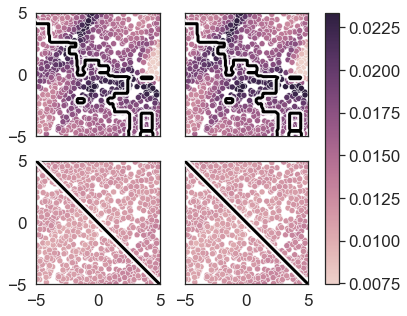

In [102]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
cmap = sns.cubehelix_palette(as_cmap=True)
gridsize = 100


int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(2,  2, figsize=(7, 5), sharey=True, sharex = True)
#~~~~~~~~~~~~~~~~~~~
import matplotlib.colors as mcolors
import matplotlib.cm as cm
vmin = min(ci_list.min(), ci_list_gt.min())*1.1
vmax = max(ci_list.max(), ci_list_gt.max())*0.9
vcenter = vmin + (vmax - vmin)/2
cmap = sns.cubehelix_palette(as_cmap=True)

normalize = mcolors.TwoSlopeNorm(vmin=vmin, vcenter = vcenter, vmax=vmax)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(attr_list[:,0])
fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(scalarmappaple, ax=axes.ravel().tolist())
cmap_single = mcolors.LinearSegmentedColormap.from_list("", ["Chartreuse", "White"])
#~~~~~~~~~~~~~~~~~~~

axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list[:,0], ax = axes[0,0], palette = cmap, hue_norm = normalize, legend = False)

axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list[:,1], ax = axes[0,1], palette = cmap, hue_norm = normalize, legend = False)
#plt.contourf(xx,yy,probs)

probs = f_prob(data_tmp)[:,1].reshape(xx.shape)
axes[1,0].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[1,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list_gt[:,0], ax = axes[1,0], palette = cmap, hue_norm = normalize, legend = False)

axes[1,1].contour(xx, yy, probs, levels=[0.5], cmap = cmap_single, vmin=-0.6, vmax=.1, linewidths=7, alpha = 0.9, zorder = 4)
axes[1,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3, zorder = 5)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list_gt[:,1], ax = axes[1,1], palette = cmap, hue_norm = normalize, legend = False)







# plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
# plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.xlim((-5,5))
plt.ylim((-5,5))
# plt.xlim((-2,2))
# plt.ylim((-2,2))
# plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.savefig('./Paper/Images/fig_toy_gpec.svg')
plt.show()

In [78]:
ci_list.max()

0.025966287

In [79]:
x_train[:20,:].max()

7.079505852789776

## Bias Variance

In [80]:
n_iterations = 100
result_list = []
for i in range(n_iterations):
    
    idx = np.random.choice(x_train.shape[0], size = x_train.shape[0], replace = True)
    tmp_train = x_train[idx,...]
    d_train = xgb.DMatrix(tmp_train, label=y_train)
    d_test = xgb.DMatrix(x_test, label=y_test)

    params = {
        "eta": 1.0,
        # "gamma": 10,
        "objective": "binary:logistic",
        "subsample": 0.5,
        "base_score": np.mean(y_train),
        "eval_metric": "logloss"
    }
    model = xgb.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

    explainer = 'kernelshap'
    if explainer == 'kernelshap':
        gt_model = f_out
        output_shape = 'singleclass'
    else:
        gt_model = f_prob
        output_shape = 'multiclass'
    f_blackbox = xgb_models.xgboost_wrapper(model = model, output_shape = output_shape)


    gpec = GPEC.GPEC_Explainer(
        f_blackbox,
        x_train,
        y_train,
        explain_method = explainer,
        use_gpec = False,
        kernel = 'WEG',
        lam = 0.5,
        rho = 0.5,
        kernel_normalization = True,
        max_batch_size = 1024,
        gpec_lr = 1,
        gpec_iterations = 100,
        use_labelnoise = False,
        learn_addn_noise = False,
        n_mc_samples = 200,
        scale_data = False,
        )


    attr_list, var_list, ci_list = gpec.explain(x_test, y_test)
    result_list.append(attr_list)

result_list = np.array(result_list)



[0]	test-logloss:0.80810
[19]	test-logloss:1.40601
done!


100%|██████████| 1000/1000 [00:04<00:00, 230.63it/s]

[0]	test-logloss:0.75981
[19]	test-logloss:1.97557


done!


100%|██████████| 1000/1000 [00:04<00:00, 235.97it/s]

[0]	test-logloss:0.85076


[19]	test-logloss:2.45886
done!


100%|██████████| 1000/1000 [00:04<00:00, 239.12it/s]

[0]	test-logloss:0.82019


[20]	test-logloss:1.31450
done!


100%|██████████| 1000/1000 [00:04<00:00, 232.53it/s]

[0]	test-logloss:0.78912


[20]	test-logloss:0.92686
done!


100%|██████████| 1000/1000 [00:04<00:00, 245.10it/s]

[0]	test-logloss:0.73868
[24]	test-logloss:1.03367


done!


100%|██████████| 1000/1000 [00:04<00:00, 244.69it/s]

[0]	test-logloss:0.72208


[20]	test-logloss:1.26836
done!


100%|██████████| 1000/1000 [00:03<00:00, 263.76it/s]

[0]	test-logloss:0.65333


[22]	test-logloss:1.39631
done!


100%|██████████| 1000/1000 [00:03<00:00, 258.20it/s]

[0]	test-logloss:0.71832
[20]	test-logloss:1.84427


done!


100%|██████████| 1000/1000 [00:03<00:00, 262.46it/s]

[0]	test-logloss:0.74881


[26]	test-logloss:0.82620
done!


100%|██████████| 1000/1000 [00:04<00:00, 246.26it/s]

[0]	test-logloss:0.96690


[19]	test-logloss:1.58088
done!


100%|██████████| 1000/1000 [00:03<00:00, 261.56it/s]

[0]	test-logloss:0.87143


[20]	test-logloss:1.28586
done!


100%|██████████| 1000/1000 [00:03<00:00, 260.63it/s]

[0]	test-logloss:0.56063
[20]	test-logloss:0.80668


done!


100%|██████████| 1000/1000 [00:04<00:00, 230.80it/s]

[0]	test-logloss:0.87188


[22]	test-logloss:0.89336
done!


100%|██████████| 1000/1000 [00:04<00:00, 242.67it/s]

[0]	test-logloss:0.91045


[30]	test-logloss:1.15061
done!


100%|██████████| 1000/1000 [00:04<00:00, 236.13it/s]

[0]	test-logloss:1.01408
[20]	test-logloss:1.54448


done!


100%|██████████| 1000/1000 [00:04<00:00, 241.46it/s]

[0]	test-logloss:0.75621


[21]	test-logloss:1.36880
done!


100%|██████████| 1000/1000 [00:04<00:00, 243.21it/s]


[0]	test-logloss:0.79865
[20]	test-logloss:1.76756
done!


100%|██████████| 1000/1000 [00:04<00:00, 236.00it/s]

[0]	test-logloss:0.68990
[25]	test-logloss:1.06120


done!


100%|██████████| 1000/1000 [00:04<00:00, 245.49it/s]


[0]	test-logloss:0.82058
[20]	test-logloss:1.86393
done!


100%|██████████| 1000/1000 [00:04<00:00, 244.62it/s]

[0]	test-logloss:0.72471


[20]	test-logloss:0.78582
done!


100%|██████████| 1000/1000 [00:04<00:00, 240.19it/s]

[0]	test-logloss:0.64027


[19]	test-logloss:1.38264
done!


100%|██████████| 1000/1000 [00:04<00:00, 236.98it/s]

[0]	test-logloss:0.76659
[22]	test-logloss:0.78672


done!


100%|██████████| 1000/1000 [00:04<00:00, 243.78it/s]

[0]	test-logloss:0.78927
[20]	test-logloss:1.38722


done!


100%|██████████| 1000/1000 [00:04<00:00, 249.58it/s]

[0]	test-logloss:0.85654


[22]	test-logloss:1.25683
done!


100%|██████████| 1000/1000 [00:04<00:00, 246.57it/s]


[0]	test-logloss:1.01133
[21]	test-logloss:1.28897
done!


100%|██████████| 1000/1000 [00:04<00:00, 248.45it/s]

[0]	test-logloss:0.65973


[19]	test-logloss:0.93951
done!


100%|██████████| 1000/1000 [00:03<00:00, 263.38it/s]

[0]	test-logloss:0.73961


[19]	test-logloss:1.60714
done!


100%|██████████| 1000/1000 [00:03<00:00, 258.24it/s]

[0]	test-logloss:0.62930
[24]	test-logloss:0.80270


done!


100%|██████████| 1000/1000 [00:03<00:00, 254.88it/s]

[0]	test-logloss:0.73767


[19]	test-logloss:1.55496
done!


100%|██████████| 1000/1000 [00:03<00:00, 265.49it/s]

[0]	test-logloss:0.82687
[20]	test-logloss:1.16596


done!


100%|██████████| 1000/1000 [00:03<00:00, 260.44it/s]

[0]	test-logloss:0.70388


[20]	test-logloss:1.23445
done!


100%|██████████| 1000/1000 [00:03<00:00, 265.18it/s]

[0]	test-logloss:0.73478
[19]	test-logloss:1.07866


done!


100%|██████████| 1000/1000 [00:03<00:00, 261.78it/s]

[0]	test-logloss:0.66862


[20]	test-logloss:0.94643
done!


100%|██████████| 1000/1000 [00:03<00:00, 266.32it/s]

[0]	test-logloss:0.71546
[19]	test-logloss:1.35766


done!


100%|██████████| 1000/1000 [00:03<00:00, 269.35it/s]

[0]	test-logloss:0.94969


[20]	test-logloss:1.49476
done!


100%|██████████| 1000/1000 [00:03<00:00, 262.22it/s]

[0]	test-logloss:0.66654


[21]	test-logloss:0.88324
done!


100%|██████████| 1000/1000 [00:04<00:00, 229.96it/s]

[0]	test-logloss:0.56345
[19]	test-logloss:1.24165


done!


100%|██████████| 1000/1000 [00:04<00:00, 228.85it/s]

[0]	test-logloss:0.67010


[20]	test-logloss:1.07075
done!


100%|██████████| 1000/1000 [00:04<00:00, 237.27it/s]

[0]	test-logloss:0.82060


[20]	test-logloss:1.60323
done!


100%|██████████| 1000/1000 [00:04<00:00, 234.76it/s]

[0]	test-logloss:0.72235
[21]	test-logloss:0.94536


done!


100%|██████████| 1000/1000 [00:04<00:00, 244.76it/s]

[0]	test-logloss:0.76355


[21]	test-logloss:1.32470
done!


100%|██████████| 1000/1000 [00:04<00:00, 241.32it/s]

[0]	test-logloss:0.64468
[21]	test-logloss:1.07789


done!


100%|██████████| 1000/1000 [00:03<00:00, 253.69it/s]

[0]	test-logloss:0.55819
[19]	test-logloss:0.98723


done!


100%|██████████| 1000/1000 [00:03<00:00, 250.46it/s]

[0]	test-logloss:0.72378


[20]	test-logloss:1.12227
done!


100%|██████████| 1000/1000 [00:04<00:00, 244.10it/s]

[0]	test-logloss:0.70519
[19]	test-logloss:1.42087


done!


100%|██████████| 1000/1000 [00:04<00:00, 233.42it/s]

[0]	test-logloss:0.68026
[19]	test-logloss:1.02867


done!


100%|██████████| 1000/1000 [00:03<00:00, 258.09it/s]


[0]	test-logloss:0.73718
[19]	test-logloss:1.45378
done!


100%|██████████| 1000/1000 [00:03<00:00, 264.75it/s]

[0]	test-logloss:0.98816


[23]	test-logloss:1.12573
done!


100%|██████████| 1000/1000 [00:03<00:00, 262.81it/s]

[0]	test-logloss:0.82886


[26]	test-logloss:1.47115
done!


100%|██████████| 1000/1000 [00:03<00:00, 261.24it/s]

[0]	test-logloss:0.65654
[21]	test-logloss:1.20949


done!


100%|██████████| 1000/1000 [00:03<00:00, 264.62it/s]

[0]	test-logloss:0.80367


[21]	test-logloss:0.96312
done!


100%|██████████| 1000/1000 [00:03<00:00, 253.42it/s]

[0]	test-logloss:0.91789
[24]	test-logloss:1.14407


done!


100%|██████████| 1000/1000 [00:03<00:00, 263.39it/s]

[0]	test-logloss:0.94066


[19]	test-logloss:1.18981
done!


100%|██████████| 1000/1000 [00:03<00:00, 263.41it/s]

[0]	test-logloss:0.75094


[26]	test-logloss:0.91645
done!


100%|██████████| 1000/1000 [00:03<00:00, 263.21it/s]

[0]	test-logloss:0.76618


[19]	test-logloss:1.33655
done!


100%|██████████| 1000/1000 [00:03<00:00, 262.41it/s]

[0]	test-logloss:0.72890


[20]	test-logloss:1.64244
done!


100%|██████████| 1000/1000 [00:03<00:00, 267.11it/s]

[0]	test-logloss:0.59341
[19]	test-logloss:0.90433


done!


100%|██████████| 1000/1000 [00:03<00:00, 260.96it/s]

[0]	test-logloss:0.65566
[19]	test-logloss:0.86152


done!


100%|██████████| 1000/1000 [00:03<00:00, 267.85it/s]

[0]	test-logloss:0.90966
[20]	test-logloss:1.63189


done!


100%|██████████| 1000/1000 [00:03<00:00, 263.40it/s]

[0]	test-logloss:0.76632


[20]	test-logloss:1.22219
done!


100%|██████████| 1000/1000 [00:03<00:00, 260.29it/s]

[0]	test-logloss:0.96017


[21]	test-logloss:1.45009
done!


100%|██████████| 1000/1000 [00:03<00:00, 264.25it/s]

[0]	test-logloss:0.79177


[19]	test-logloss:1.80679
done!


100%|██████████| 1000/1000 [00:03<00:00, 263.96it/s]

[0]	test-logloss:0.66035


[19]	test-logloss:1.18917
done!


100%|██████████| 1000/1000 [00:03<00:00, 265.80it/s]

[0]	test-logloss:0.65884
[20]	test-logloss:0.90656


done!


100%|██████████| 1000/1000 [00:03<00:00, 265.84it/s]

[0]	test-logloss:0.86648
[24]	test-logloss:1.63098


done!


100%|██████████| 1000/1000 [00:03<00:00, 266.05it/s]

[0]	test-logloss:0.85386


[19]	test-logloss:1.09315
done!


100%|██████████| 1000/1000 [00:03<00:00, 261.30it/s]

[0]	test-logloss:0.99083


[24]	test-logloss:1.57819
done!


100%|██████████| 1000/1000 [00:03<00:00, 263.33it/s]

[0]	test-logloss:0.56709


[19]	test-logloss:1.58225
done!


100%|██████████| 1000/1000 [00:03<00:00, 258.28it/s]


[0]	test-logloss:0.81929
[20]	test-logloss:1.61843
done!


100%|██████████| 1000/1000 [00:04<00:00, 226.33it/s]

[0]	test-logloss:0.67213


[20]	test-logloss:1.13753
done!


100%|██████████| 1000/1000 [00:04<00:00, 219.20it/s]

[0]	test-logloss:0.71381
[22]	test-logloss:0.98861


done!


100%|██████████| 1000/1000 [00:04<00:00, 244.10it/s]

[0]	test-logloss:0.87391


[21]	test-logloss:1.14291
done!


100%|██████████| 1000/1000 [00:04<00:00, 225.74it/s]

[0]	test-logloss:0.76536


[20]	test-logloss:1.22298
done!


100%|██████████| 1000/1000 [00:04<00:00, 209.40it/s]

[0]	test-logloss:0.81589
[21]	test-logloss:1.14970


done!


100%|██████████| 1000/1000 [00:04<00:00, 249.60it/s]

[0]	test-logloss:0.82099


[24]	test-logloss:1.08320
done!


100%|██████████| 1000/1000 [00:04<00:00, 246.98it/s]

[0]	test-logloss:0.83468


[21]	test-logloss:1.80499
done!


100%|██████████| 1000/1000 [00:04<00:00, 234.52it/s]

[0]	test-logloss:0.88307


[32]	test-logloss:2.06592
done!


100%|██████████| 1000/1000 [00:04<00:00, 200.44it/s]

[0]	test-logloss:0.94985


[21]	test-logloss:1.12233
done!


100%|██████████| 1000/1000 [00:04<00:00, 206.87it/s]

[0]	test-logloss:0.87948


[28]	test-logloss:1.07640
done!


100%|██████████| 1000/1000 [00:04<00:00, 224.23it/s]

[0]	test-logloss:0.67528


[20]	test-logloss:1.05390
done!


100%|██████████| 1000/1000 [00:04<00:00, 240.78it/s]

[0]	test-logloss:0.67588


[21]	test-logloss:1.45522
done!


100%|██████████| 1000/1000 [00:04<00:00, 243.86it/s]

[0]	test-logloss:0.72481
[21]	test-logloss:0.85476


done!


100%|██████████| 1000/1000 [00:04<00:00, 243.49it/s]

[0]	test-logloss:0.90364


[27]	test-logloss:1.33875
done!


100%|██████████| 1000/1000 [00:04<00:00, 246.46it/s]

[0]	test-logloss:0.70717


[19]	test-logloss:1.20063
done!


100%|██████████| 1000/1000 [00:04<00:00, 242.19it/s]

[0]	test-logloss:0.70166


[29]	test-logloss:1.06453
done!


100%|██████████| 1000/1000 [00:04<00:00, 239.72it/s]

[0]	test-logloss:0.72713
[20]	test-logloss:1.38857


done!


100%|██████████| 1000/1000 [00:04<00:00, 226.12it/s]

[0]	test-logloss:0.80532


[19]	test-logloss:1.28742
done!


100%|██████████| 1000/1000 [00:04<00:00, 221.01it/s]

[0]	test-logloss:0.87310


[20]	test-logloss:1.32602
done!


100%|██████████| 1000/1000 [00:04<00:00, 203.22it/s]

[0]	test-logloss:0.90534


[20]	test-logloss:1.50119
done!


100%|██████████| 1000/1000 [00:04<00:00, 219.35it/s]

[0]	test-logloss:0.71852


[20]	test-logloss:1.62634
done!


100%|██████████| 1000/1000 [00:04<00:00, 216.09it/s]

[0]	test-logloss:0.65846


[20]	test-logloss:1.01038
done!


100%|██████████| 1000/1000 [00:04<00:00, 230.38it/s]

[0]	test-logloss:0.81283


[36]	test-logloss:0.96651
done!


100%|██████████| 1000/1000 [00:04<00:00, 234.26it/s]

[0]	test-logloss:0.64847


[19]	test-logloss:1.15792
done!


100%|██████████| 1000/1000 [00:04<00:00, 230.68it/s]

[0]	test-logloss:0.70072
[19]	test-logloss:1.66951


done!


100%|██████████| 1000/1000 [00:04<00:00, 239.28it/s]

[0]	test-logloss:0.83901


[21]	test-logloss:1.30157
done!


100%|██████████| 1000/1000 [00:04<00:00, 234.94it/s]

[0]	test-logloss:0.71028
[20]	test-logloss:1.49534


done!


100%|██████████| 1000/1000 [00:04<00:00, 239.00it/s]

[0]	test-logloss:0.81749


[22]	test-logloss:0.89400
done!


100%|██████████| 1000/1000 [00:04<00:00, 226.22it/s]

[0]	test-logloss:0.62271
[20]	test-logloss:1.30059


done!


100%|██████████| 1000/1000 [00:04<00:00, 242.93it/s]

[0]	test-logloss:0.66747


[21]	test-logloss:1.13648
done!


100%|██████████| 1000/1000 [00:04<00:00, 234.69it/s]


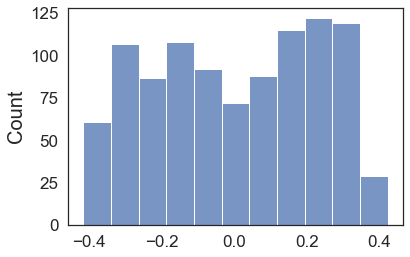

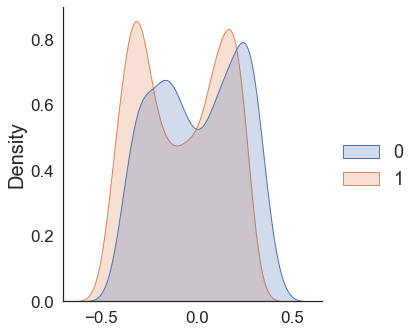

In [81]:
bias = result_list.mean(axis = 0) - attr_list_gt
sns.histplot(bias[:,0])
plt.show()
sns.displot(bias, kind = 'kde', fill = True)
plt.show()

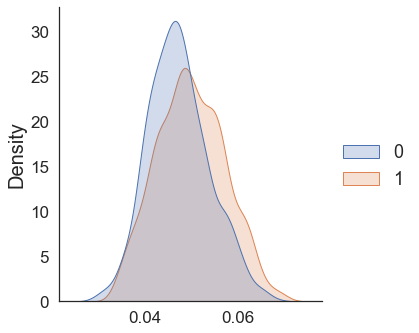

In [82]:
var = result_list.var(axis = 0)
sns.displot(var, kind = 'kde', fill = True)

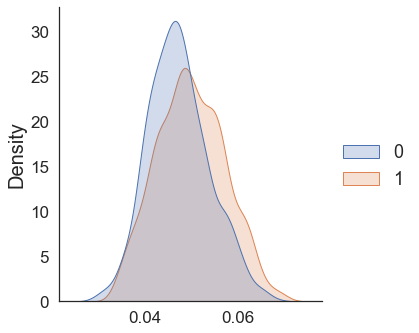

In [83]:
var = result_list.var(axis = 0)
sns.displot(var, kind = 'kde', fill = True)

In [85]:
var.mean(axis = 0)**0.5

array([0.21739043, 0.22326509])

## LIME

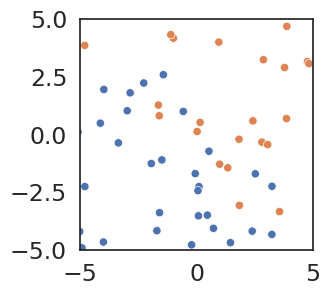

In [173]:
np.random.seed(2)
def f_data(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y + np.random.normal(0, 2.0, size = len(x))
    return (output >= 0)*1.

def f_out(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y
    return output

def f_prob(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y
    output = utils_np.sigmoid(output)
    return np.vstack((1-output, output)).transpose()

def f_prob_singleclass(data):
    x = data[:,0]
    y = data[:,1]

    output = x+y
    output = utils_np.sigmoid(output)
    return output
# def f(data):

#     x = data[:,0]
#     y = data[:,1]

#     output = np.abs(x) + y + np.random.normal(0, 1.0, size = len(x))
#     return (output >= 0)*1.

def db(data):
    x = data[:,0]
    y = data[:,1]

    output = -x
    return output
x_train = np.random.uniform(-10,10, size = (200,2))
x_test = np.random.uniform(-5,5, size = (1000,2))
y_train = f_data(x_train)
y_test = f_data(x_test)

fig, ax = plt.subplots(1,1, figsize = (3,3))
sns.scatterplot(x = x_train[:,0], y = x_train[:,1], hue = f_data(x_train))
plt.ylim((-5,5))
plt.xlim((-5,5))
ax.get_legend().remove()
plt.show()


In [174]:


d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

params = {
    "eta": 1.0,
    # "gamma": 10,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgb.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

pred =(model.predict(d_test) >= 0.5)*1
# see how well we can order people by survival
print(metrics.accuracy_score(y_test, pred))
print(metrics.roc_auc_score(y_test, pred))
print('done!')
'''
model_path = './Files/Models/model_census.json'
model = xgb.Booster()
model.load_model(model_path)
'''

[0]	test-logloss:0.59463
[24]	test-logloss:0.53163
0.813
0.8132259408193018
done!


"\nmodel_path = './Files/Models/model_census.json'\nmodel = xgb.Booster()\nmodel.load_model(model_path)\n"

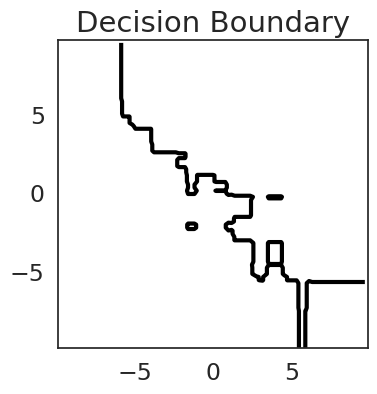

In [175]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(1,  1, figsize=(4, 4), sharey=True, sharex = True)
axes.contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)

# axes[1,0].get_legend().remove()
# axes[1,1].get_legend().remove()


plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()

In [184]:
explainer = 'lime'
if explainer == 'kernelshap':
    gt_model = f_prob_singleclass
    output_shape = 'singleclass'
else:
    gt_model = f_prob
    output_shape = 'multiclass'
f_blackbox = xgb_models.xgboost_wrapper(model = model, output_shape = output_shape)

lam = 5
rho = 0.01
gpec = GPEC.GPEC_Explainer(
    f_blackbox,
    x_train,
    y_train,
    explain_method = explainer,
    use_gpec = False,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 50,
    )


attr_list, var_list, ci_list = gpec.explain(x_test, y_test)
print('DONE')

gpec = GPEC.GPEC_Explainer(
    gt_model,
    x_train,
    y_train,
    explain_method = explainer,
    use_gpec = False,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 50,
    )


attr_list_gt, var_list_gt, ci_list_gt = gpec.explain(x_test, y_test)

done!


100%|██████████| 1000/1000 [00:06<00:00, 150.71it/s]


DONE


100%|██████████| 1000/1000 [00:05<00:00, 167.53it/s]


In [185]:
# spearman rank correlation
#using absolute value
import scipy
tmp = np.abs(attr_list)
order = tmp.argsort(axis = 1)
ranks = order.argsort(axis = 1)+1
a = ranks

tmp = np.abs(attr_list_gt)
order = tmp.argsort(axis = 1)
ranks = order.argsort(axis = 1)+1
b = ranks

corr_list = []
for i in range(a.shape[0]):
    corr_list.append(scipy.stats.spearmanr(a[i,:], b[i,:])[0])
corr_list = np.array(corr_list)
np.tanh(np.arctanh(corr_list).mean())

0.9999999999999999

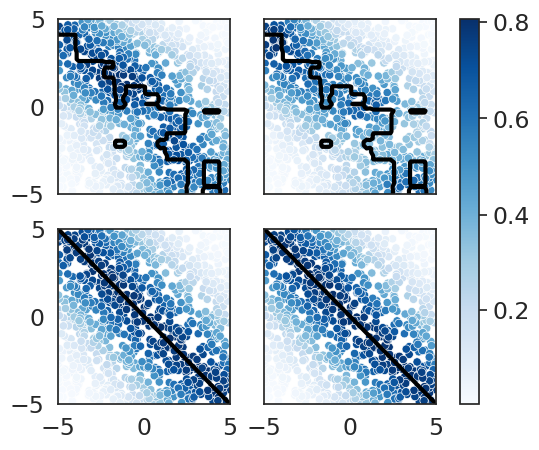

In [194]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(2,  2, figsize=(7, 5), sharey=True, sharex = True)

#~~~~~~~~~~~~~~~~~~~
import matplotlib.colors as mcolors
import matplotlib.cm as cm
vmin = min(attr_list.min(), attr_list_gt.min())
vmax = min(attr_list.max(), attr_list_gt.max())
vcenter = vmin + (vmin + vmax) / 2
cmap = "Blues"

normalize = mcolors.TwoSlopeNorm(vmin=vmin, vcenter = vcenter, vmax=vmax)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(attr_list[:,0])
fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(scalarmappaple, ax=axes.ravel().tolist())
#~~~~~~~~~~~~~~~~~~~

axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list[:,0], ax = axes[0,0], palette = cmap, legend = False, norm = normalize)

axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list[:,1], ax = axes[0,1], palette = cmap, legend = False, norm = normalize)
#plt.contourf(xx,yy,probs)

probs = f_prob(data_tmp)[:,1].reshape(xx.shape)
axes[1,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list_gt[:,0], ax = axes[1,0], palette = cmap, legend = False, norm = normalize)

axes[1,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = attr_list_gt[:,1], ax = axes[1,1], palette = cmap, legend = False, norm = normalize)



# plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
# plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
# plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.show()

## Mean Squared Error (MSE)

In [187]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(attr_list_gt[:,0], attr_list[:,0]))
print(mean_squared_error(attr_list_gt[:,1], attr_list[:,1]))
# np.linalg.norm(attr_list - attr_list_gt)

0.012854540950922515
0.018949717507559024


## Plot feature importance norm

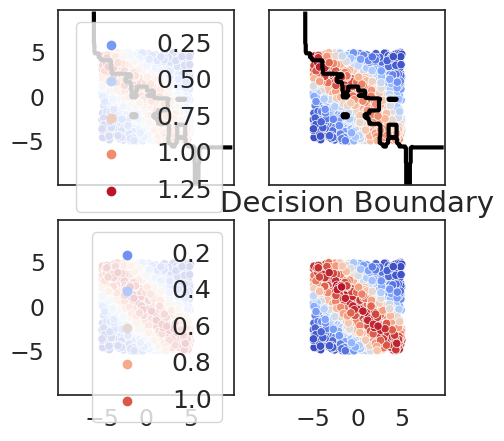

In [188]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(2,  2, figsize=(5, 5), sharey=True, sharex = True)
axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list, axis = 1), ax = axes[0,0], palette = "coolwarm")

axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list, axis = 1), ax = axes[0,1], palette = "coolwarm")
# axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
#plt.contourf(xx,yy,probs)

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list_gt, axis = 1), ax = axes[1,0], palette = "coolwarm")

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = np.linalg.norm(attr_list_gt, axis = 1), ax = axes[1,1], palette = "coolwarm")

# axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()


plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()

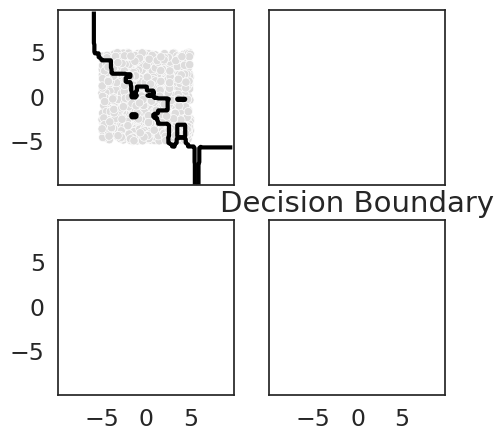

0.0


In [189]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

disagree_list = (attr_list.argmax(axis = 1) != attr_list_gt.argmax(axis = 1))*1

fig, axes = plt.subplots(2,  2, figsize=(5, 5), sharey=True, sharex = True)
axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = disagree_list, ax = axes[0,0], palette = "coolwarm")

axes[0,0].get_legend().remove()
#plt.contourf(xx,yy,probs)


plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()
print(disagree_list.mean())

## Robustness

0.41329976417575276
0.2931328365580949


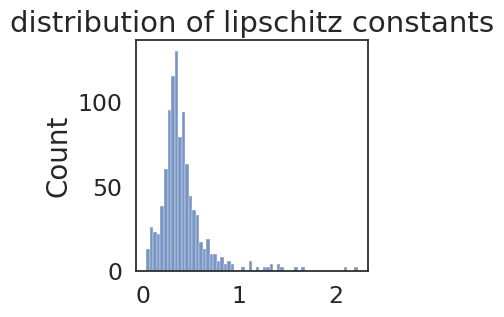

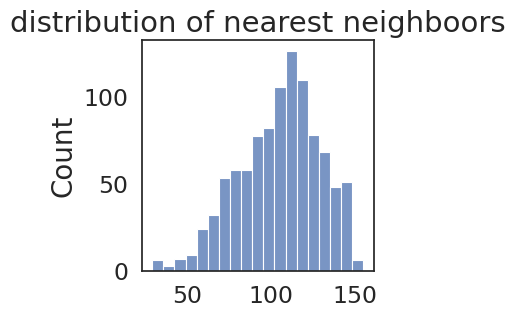

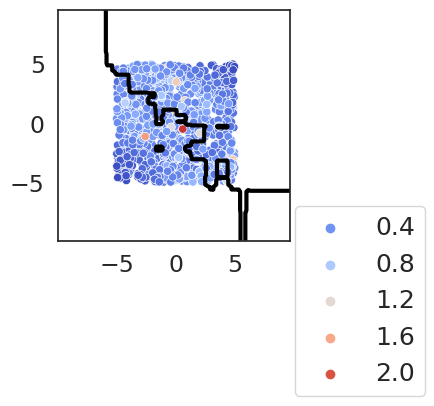

In [190]:
def robustness(x_test, attr_list, eps):
    dist_mat = scipy.spatial.distance_matrix(x_test, x_test)
    attr_mat = scipy.spatial.distance_matrix(attr_list, attr_list)
    lip_mat = np.divide(attr_mat, dist_mat, out=np.zeros_like(attr_mat), where=dist_mat!=0)

    lip_list = []
    nn_list = []
    for i in range(x_test.shape[0]):
        sample = x_test[i,...]
        nn_idx = np.where(dist_mat[i,:] < eps)[0]
        nn_list.append(len(nn_idx))
        l = lip_mat[i,nn_idx].max()
        lip_list.append(l)
    lip_list = np.array(lip_list)
    nn_list = np.array(nn_list)
    return lip_list, nn_list


eps = 2
lip_list, nn_list = robustness(x_test, attr_list, eps)
lip_list_gt, _ = robustness(x_test, attr_list_gt, eps)
print(lip_list.mean())
print(lip_list_gt.mean())


########### plot
fig, axes = plt.subplots(1,  1, figsize=(3, 3), sharey=True, sharex = True)
sns.histplot(lip_list)
plt.title("distribution of lipschitz constants")
plt.show()

fig, axes = plt.subplots(1,  1, figsize=(3, 3), sharey=True, sharex = True)
sns.histplot(nn_list)
plt.title("distribution of nearest neighboors")
plt.show()

fig, axes = plt.subplots(1,  1, figsize=(3, 3), sharey=True, sharex = True)
axes.contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = lip_list, ax = axes, palette = "coolwarm")
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)
plt.show()


In [152]:
explainer = 'lime'
if explainer == 'kernelshap':
    gt_model = f_prob_singleclass
    output_shape = 'singleclass'
else:
    gt_model = f_prob
    output_shape = 'multiclass'
f_blackbox = xgb_models.xgboost_wrapper(model = model, output_shape = output_shape)

x_tmp = np.random.uniform(-10,10, size = (40,2))

linspace_list = []
for feat_idx in range(x_train.shape[1]):
    linspace_list.append(np.linspace(-10, 10, 20, dtype = x_train.dtype))

xx_list = np.meshgrid(*linspace_list)
xx_list = [xx.transpose() for xx in xx_list]
ravel_list = [xx.ravel() for xx in xx_list]
x_tmp = np.vstack(ravel_list).transpose()
y_tmp = np.zeros(x_tmp.shape[0])

lam = 1
rho = 0.5
gpec = GPEC.GPEC_Explainer(
    f_blackbox,
    x_tmp,
    y_tmp,
    explain_method = explainer,
    use_gpec = True,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 200,
    # manifold_samples = manifold_samples,
    # geo_matrix = geo_matrix,
    # tr_attributions = tr_attributions,
    calc_attr_during_pred = False,
    )
manifold_samples = gpec.manifold_samples
geo_matrix = gpec.geo_matrix
# tr_attributions = attr_list

_, var_list, ci_list = gpec.explain(x_test, y_test)
print('DONE')

gpec = GPEC.GPEC_Explainer(
    gt_model,
    x_tmp,
    y_tmp,
    explain_method = explainer,
    use_gpec = True,
    kernel = 'WEG',
    lam = lam,
    rho = rho,
    kernel_normalization = True,
    max_batch_size = 1024,
    gpec_lr = 1,
    gpec_iterations = 100,
    use_labelnoise = False,
    learn_addn_noise = False,
    n_mc_samples = 200,
    scale_data = False,
    max_manifold_samples = 200,
    # manifold_samples = manifold_samples_gt,
    # geo_matrix = geo_matrix_gt,
    # tr_attributions = tr_attributions_gt,
    calc_attr_during_pred = False,
    )
manifold_samples_gt = gpec.manifold_samples
geo_matrix_gt = gpec.geo_matrix
# tr_attributions_gt = attr_list_gt


_, var_list_gt, ci_list_gt = gpec.explain(x_test, y_test)

done!
Generating Explanations...


100%|██████████| 400/400 [00:02<00:00, 146.20it/s]


Sampling Boundary...


100%|██████████| 598/598 [00:00<00:00, 18201.04it/s]


# Samples Not Converged: 322
Avg Gap: 0.19399661751267333
Max Gap: 0.4373440444469452
Samples limited to: 200
Building EG Kernel...


define_rTree:   0%|          | 0/200 [00:00<?, ?it/s]divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
di

Training GP...
Number of Batches: 1


Batch Progress: 0it [00:00, ?it/s]

----------------
device: cuda
Optimizer: Adam


100%|██████████| 100/100 [00:01<00:00, 96.45it/s, Loss=35.9]
Batch Progress: 1it [00:01,  1.04s/it]


done!
Training Done!


Batch Progress: 1it [00:00, 34.26it/s]


DONE
Generating Explanations...


100%|██████████| 400/400 [00:02<00:00, 166.55it/s]


Sampling Boundary...


100%|██████████| 588/588 [00:00<00:00, 332468.42it/s]


# Samples Not Converged: 0
Avg Gap: 0
Max Gap: 0
Samples limited to: 200
Building EG Kernel...


define_rTree:   0%|          | 0/200 [00:00<?, ?it/s]divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
di

Training GP...
Number of Batches: 1


Batch Progress: 0it [00:00, ?it/s]

----------------
device: cuda
Optimizer: Adam


100%|██████████| 100/100 [00:01<00:00, 94.67it/s, Loss=177]
Batch Progress: 1it [00:01,  1.06s/it]


done!
Training Done!


Batch Progress: 1it [00:00, 32.77it/s]


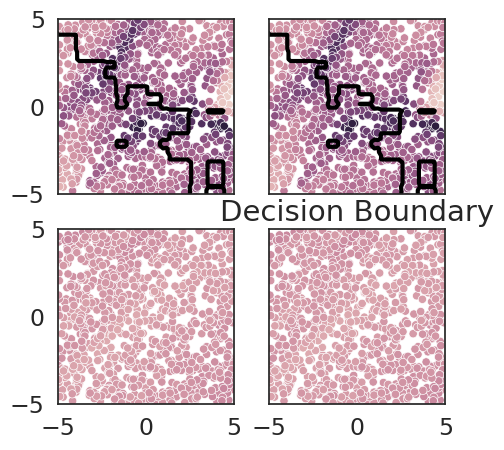

In [76]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
cmap = sns.cubehelix_palette(as_cmap=True)
gridsize = 100


int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(2,  2, figsize=(5, 5), sharey=True, sharex = True)
normalize = mcolors.TwoSlopeNorm(vmin=ci_list[:,0].min(), vcenter = ci_list[:,0].mean(), vmax=ci_list[:,0].max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(ci_list[:,0])
# plt.colorbar(scalarmappaple)

axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list[:,0], ax = axes[0,0], palette = cmap, hue_norm = normalize, legend = False)

axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list[:,1], ax = axes[0,1], palette = cmap, hue_norm = normalize, legend = False)
#plt.contourf(xx,yy,probs)

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list_gt[:,0], ax = axes[1,0], palette = cmap, hue_norm = normalize, legend = False)

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list_gt[:,1], ax = axes[1,1], palette = cmap, hue_norm = normalize, legend = False)







# plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
# plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.xlim((-5,5))
plt.ylim((-5,5))
# plt.xlim((-2,2))
# plt.ylim((-2,2))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()

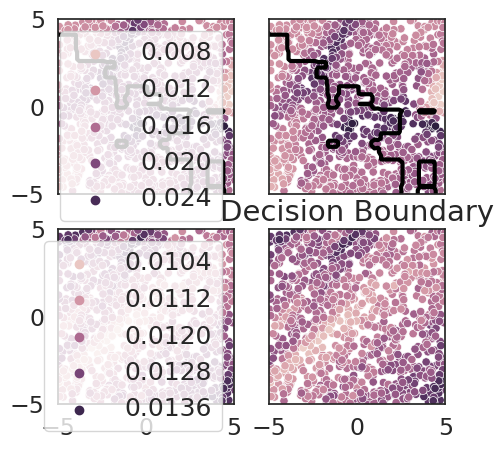

In [74]:
gridsize = 100
int1 = (x_train[:,0].max() - x_train[:,0].min()) / 100
int2 = (x_train[:,1].max() - x_train[:,1].min()) / 100
xx, yy = np.mgrid[x_train[:,0].min():x_train[:,0].max():int1, x_train[:,1].min():x_train[:,1].max():int2]
grid = np.c_[xx.ravel(), yy.ravel()]

data_tmp = grid
#data_tmp = pd.DataFrame(data_tmp, columns = X_train.columns)
probs = model.predict(xgb.DMatrix(data_tmp)).reshape(xx.shape)

fig, axes = plt.subplots(2,  2, figsize=(5, 5), sharey=True, sharex = True)
axes[0,0].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list[:,0], ax = axes[0,0], palette = sns.cubehelix_palette(as_cmap=True))

axes[0,1].contour(xx, yy, probs, levels=[0.5], cmap = "Greys", vmin=-0.6, vmax=.1, linewidths=3)
sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list[:,1], ax = axes[0,1], palette = sns.cubehelix_palette(as_cmap=True))
# axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
#plt.contourf(xx,yy,probs)

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list_gt[:,0], ax = axes[1,0], palette = sns.cubehelix_palette(as_cmap=True))

sns.scatterplot(x = x_test[:,0], y = x_test[:,1], hue = ci_list_gt[:,1], ax = axes[1,1], palette = sns.cubehelix_palette(as_cmap=True))

# axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()


# plt.xlim((x_train[:,0].min() ,x_train[:,0].max() ))
# plt.ylim((x_train[:,1].min() ,x_train[:,1].max() ))
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.title('Decision Boundary')
# plt.xlabel(feat1)
# plt.ylabel(feat2)
plt.show()

## Bias Variance

In [ ]:
n_iterations = 10
result_list = []
for i in range(n_iterations):
    
    idx = np.random.choice(x_train.shape[0], size = x_train.shape[0], replace = True)
    tmp_train = x_train[idx,...]
    d_train = xgb.DMatrix(tmp_train, label=y_train)
    d_test = xgb.DMatrix(x_test, label=y_test)

    params = {
        "eta": 1.0,
        # "gamma": 10,
        "objective": "binary:logistic",
        "subsample": 0.5,
        "base_score": np.mean(y_train),
        "eval_metric": "logloss"
    }
    model = xgb.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

    explainer = 'kernelshap'
    if explainer == 'kernelshap':
        gt_model = f_out
        output_shape = 'singleclass'
    else:
        gt_model = f_prob
        output_shape = 'multiclass'
    f_blackbox = xgb_models.xgboost_wrapper(model = model, output_shape = output_shape)


    gpec = GPEC.GPEC_Explainer(
        f_blackbox,
        x_train,
        y_train,
        explain_method = explainer,
        use_gpec = False,
        kernel = 'WEG',
        lam = 0.5,
        rho = 0.5,
        kernel_normalization = True,
        max_batch_size = 1024,
        gpec_lr = 1,
        gpec_iterations = 100,
        use_labelnoise = False,
        learn_addn_noise = False,
        n_mc_samples = 200,
        scale_data = False,
        )


    attr_list, var_list, ci_list = gpec.explain(x_test, y_test)
    result_list.append(attr_list)

result_list = np.array(result_list)



[0]	test-logloss:0.71301
[20]	test-logloss:1.31455
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:0.98105
[19]	test-logloss:1.38975
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:1.07698
[26]	test-logloss:1.77855
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:0.89887
[21]	test-logloss:1.09104
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:0.67581
[19]	test-logloss:1.35025
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:0.66061
[19]	test-logloss:1.18891
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:0.83375
[22]	test-logloss:1.49530
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:1.02542
[25]	test-logloss:1.49222
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:0.67746
[19]	test-logloss:1.22760
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[0]	test-logloss:0.70702
[23]	test-logloss:0.93176
done!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

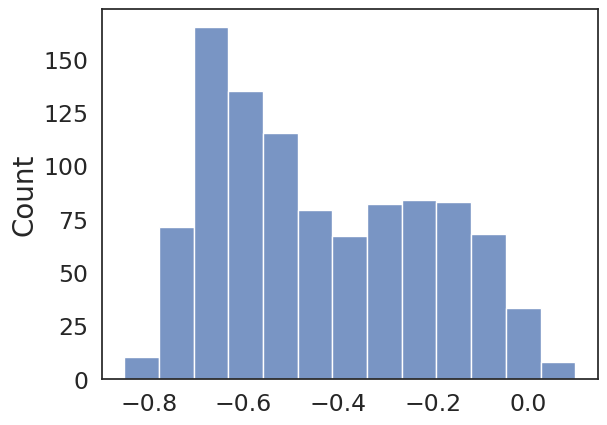

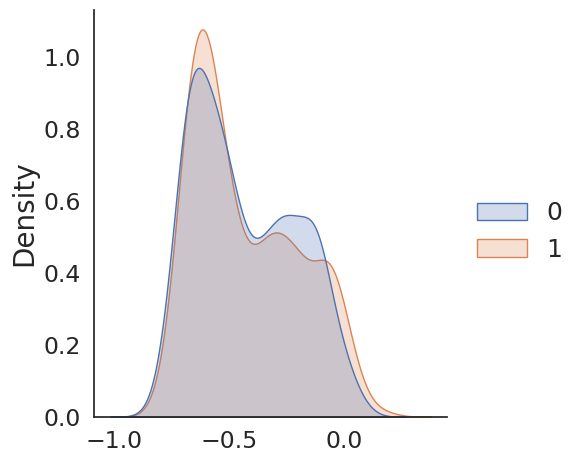

In [ ]:
bias = result_list.mean(axis = 0) - attr_list_gt
sns.histplot(bias[:,0])
plt.show()
sns.displot(bias, kind = 'kde', fill = True)
plt.show()

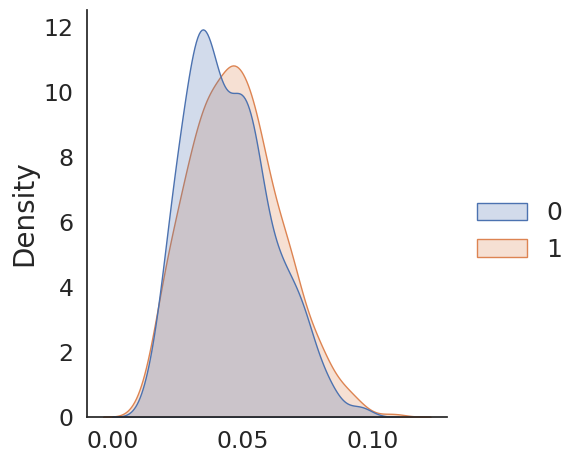

In [ ]:
var = result_list.var(axis = 0)
sns.displot(var, kind = 'kde', fill = True)

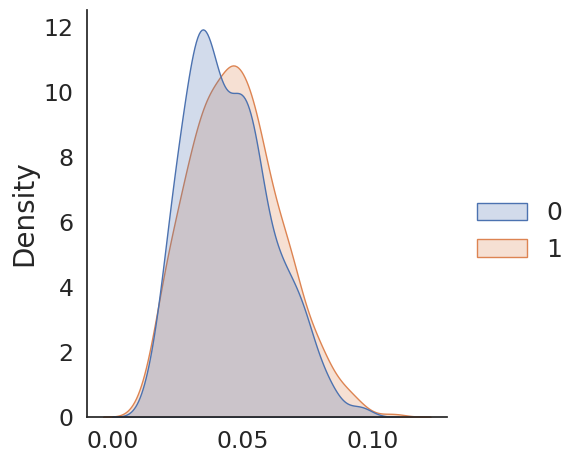

In [ ]:
var = result_list.var(axis = 0)
sns.displot(var, kind = 'kde', fill = True)